# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
import scipy.io as sio
import Event_Handle_red as  eh
# import hdf5storage
# datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total_2_distancias_red.mat')
# conjunto_datos= datos_matlab.get('photodefbox2_todo_fil5')

# npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# npzfile.files
path = "/home/rgadea/experimentos/viherbos/"
data_file = "MOVIE_DATA_batch1.h5"
json_file = "CUBE.json"
def cart2pol(x, y,z):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi,z)


pepito1=eh.Event_Handler(path, data_file, json_file)
idea1=pepito1.DATA_A.shape #obtengo el numero de muestras

entradas_sensorsA11=np.zeros([idea1[0],20,175])
entradas_sensorsB11=np.zeros([idea1[0],20,175])
coordenadas11=np.zeros([idea1[0],3])
entradas_sensorsA21=np.zeros([idea1[0],20,175])
entradas_sensorsB21=np.zeros([idea1[0],20,175])
coordenadas21=np.zeros([idea1[0],3])
for i in range(idea1[0]):
    DATA1=pepito1(i)
    entradas_sensorsA11[i]=DATA1['DATA_A1'];
    entradas_sensorsB11[i]=DATA1['DATA_B1'];    
    veamos=DATA1['TRUE1']
    polares=cart2pol(veamos[0], veamos[1], veamos[2])
    coordenadas11[i]=np.asarray(polares)
    entradas_sensorsA21[i]=DATA1['DATA_A2'];
    entradas_sensorsB21[i]=DATA1['DATA_B2'];    
    veamos=DATA1['TRUE2']
    polares=cart2pol(veamos[0], veamos[1], veamos[2])
    coordenadas21[i]=np.asarray(polares)

data_file = "MOVIE_DATA_batch2.h5"
pepito2=eh.Event_Handler(path, data_file, json_file)
idea2=pepito2.DATA_A.shape #obtengo el numero de muestras

entradas_sensorsA12=np.zeros([idea2[0],20,175])
entradas_sensorsB12=np.zeros([idea2[0],20,175])
coordenadas12=np.zeros([idea2[0],3])
entradas_sensorsA22=np.zeros([idea2[0],20,175])
entradas_sensorsB22=np.zeros([idea2[0],20,175])
coordenadas22=np.zeros([idea2[0],3])
for i in range(idea2[0]):
    DATA2=pepito2(i)
    entradas_sensorsA12[i]=DATA2['DATA_A1'];
    entradas_sensorsB12[i]=DATA2['DATA_B1'];    
    veamos=DATA2['TRUE1']
    polares=cart2pol(veamos[0], veamos[1], veamos[2])
    coordenadas12[i]=np.asarray(polares)
    entradas_sensorsA22[i]=DATA2['DATA_A2'];
    entradas_sensorsB22[i]=DATA2['DATA_B2'];    
    veamos=DATA2['TRUE2']
    polares=cart2pol(veamos[0], veamos[1], veamos[2])
    coordenadas22[i]=np.asarray(polares)    

entradas_sensorsA1=np.concatenate((entradas_sensorsA11,entradas_sensorsA12), axis=0)
entradas_sensorsA2=np.concatenate((entradas_sensorsA21,entradas_sensorsA22), axis=0)   
coordenadas1=np.concatenate((coordenadas11,coordenadas12), axis=0)


entradas_sensorsB1=np.concatenate((entradas_sensorsB11,entradas_sensorsB12), axis=0)
entradas_sensorsB2=np.concatenate((entradas_sensorsB21,entradas_sensorsB22), axis=0)  
coordenadas2=np.concatenate((coordenadas21,coordenadas22), axis=0)

(17064, 3500)
(17064, 3500)
(17064, 1)
(16937, 3500)
(16937, 3500)
(16937, 1)


In [4]:
    
np.savez('../conjuntos_datos_nuevos_2020/19_12_2019', entradas_sensorsA1,entradas_sensorsB1, coordenadas1,entradas_sensorsA2,entradas_sensorsB2, coordenadas2 )

In [5]:
energia=np.sum(entradas_sensorsA1, axis=0)

In [6]:
conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos_entradas A shape: (68002, 20, 175)
conjunto_datos_entradas B shape: (68002, 20, 175)
conjunto_datos_salidas shape: (68002, 3)


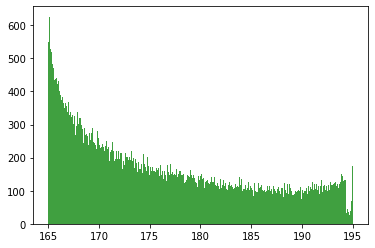

In [7]:
n, bins, patches = plt.hist(conjunto_datos_salidas[:,0], 400, density=0, facecolor='green', alpha=0.75)

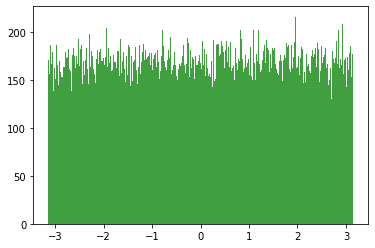

In [8]:
n, bins, patches = plt.hist(conjunto_datos_salidas[:,1], 400, density=0, facecolor='green', alpha=0.75)

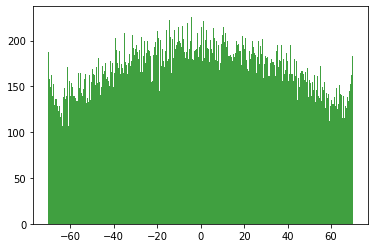

In [9]:
n, bins, patches = plt.hist(conjunto_datos_salidas[:,2], 400, density=0, facecolor='green', alpha=0.75)

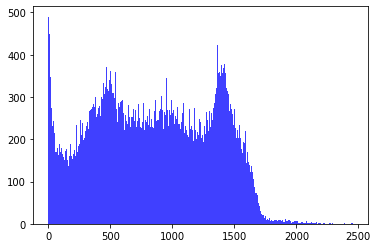

In [10]:
img_rows_t=20
img_cols_t=175
energia1B=conjunto_datos_entradasB.reshape(conjunto_datos_entradasB.shape[0], img_rows_t*img_cols_t)


energia2B=np.sum(energia1B, axis=1)

n1, bins1, patches1=plt.hist(energia2B,400, density=0, facecolor='blue', alpha=0.75)

In [11]:
print(n1.max())

490.0


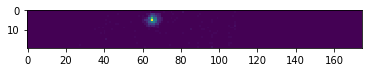

26362 181.29176604011835 -135.90053319765363 -33.12428283691406


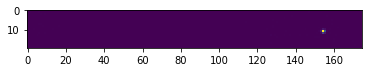

18094 190.40497853827333 47.05877473913742 11.322822570800781


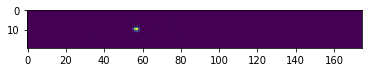

45335 188.2265100996255 -153.54857552436715 2.669490098953247


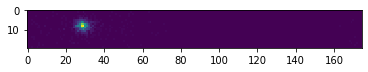

22239 167.12265521688064 153.59668076010854 3.2004523277282715


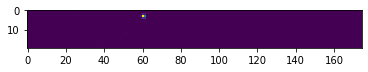

60550 190.40110700787992 -145.930692499917 -44.690528869628906


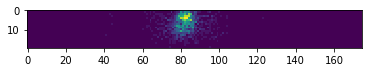

21450 165.64693431479114 -102.80947597714763 -3.2795205116271973


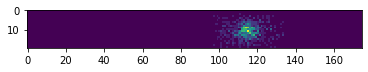

59620 165.99872135853397 -33.61613181988252 8.520263671875


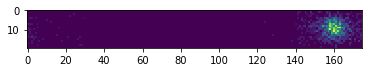

65796 166.04556022987123 56.425905644961645 -8.033291816711426


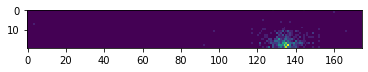

8630 165.4451930201821 6.7615943029101295 57.04447937011719


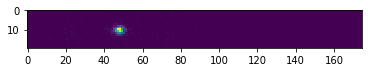

63194 183.17649056845175 -171.708825683976 6.275897026062012


In [12]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(idea, conjunto_datos_salidas[idea,0],conjunto_datos_salidas[idea,1]*180/np.pi,conjunto_datos_salidas[idea,2])

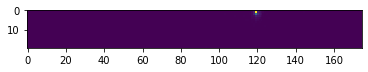

66247 170.3824836697924 -26.425602219072537 -40.216514587402344


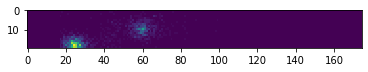

7552 170.9435279843847 -147.38587452301243 0.5799381732940674
24
[24 60]
[[14 41]
 [13 45]
 [13 44]
 [10 60]
 [ 6 44]]


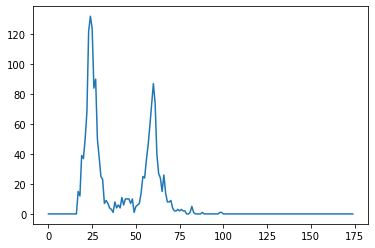

In [83]:
from scipy import signal as fp1
from gammapy import detect as fp2
from skimage.feature import peak as fp3
idea=7552
plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
plt.show()
print(idea, conjunto_datos_salidas[idea,0],conjunto_datos_salidas[idea,1]*180/np.pi,conjunto_datos_salidas[idea,2])

i=0

muestras=conjunto_datos_entradasB.shape[0]
veamos3=np.zeros([muestras,175])
veamos3[0]=np.sum(conjunto_datos_entradasB[idea], axis=0)
indice=np.argmax(veamos3[0], axis=0)
print (indice)
indices = fp1.find_peaks(veamos3[0], height=40, distance=5)[0]
indices2 = fp3.peak_local_max(conjunto_datos_entradasB[idea],threshold_rel =0.05, min_distance=4)
print(indices)
print(indices2)
plt.plot(veamos3[0])

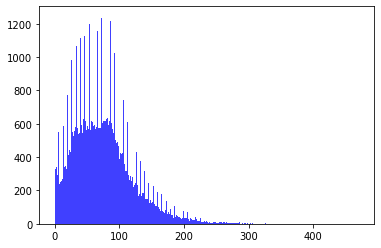

In [84]:
energia1A=conjunto_datos_entradasA.reshape(conjunto_datos_entradasA.shape[0], img_rows_t*img_cols_t)
energia2A=np.sum(energia1A, axis=1)
n2, bins2, patches2=plt.hist(energia2A,400, density=0, facecolor='blue', alpha=0.75)

In [85]:
energia2B_b=energia2B.reshape(energia2B.shape[0],1)



In [ ]:
veamos=np.where((energia2B_b>1300).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt=conjunto_datos_entradasA[veamos]

conjunto_datos_entradasB_filt=conjunto_datos_entradasB[veamos]

conjunto_datos_salidas_filt=conjunto_datos_salidas[veamos]

In [ ]:
energia1C=conjunto_datos_entradasB_filt.reshape(conjunto_datos_entradasB_filt.shape[0], img_rows_t*img_cols_t)
energia2C=np.sum(energia1C, axis=1)
n3, bins3, patches3=plt.hist(energia2C,400, density=0, facecolor='blue', alpha=0.75)

In [ ]:
    
np.savez('../conjuntos_datos_nuevos_2020/19_12_2019_filt',conjunto_datos_entradasA_filt, conjunto_datos_entradasB_filt, conjunto_datos_salidas_filt)

In [ ]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB_filt.shape[0])
    plt.imshow(conjunto_datos_entradasB_filt[idea], cmap='viridis')
    plt.show()
    print(idea, conjunto_datos_salidas_filt[idea,0],conjunto_datos_salidas_filt[idea,1]*180/np.pi,conjunto_datos_salidas_filt[idea,2])